In [64]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, LayerNormalization, MultiHeadAttention, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import get_file
from sklearn.metrics import precision_score, recall_score

In [65]:
# Download and preprocess the Imagenette dataset
def preprocess_image(image, label, image_size=(224, 224)):
    image = tf.image.resize(image, image_size)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image, label

def prepare_dataset(batch_size=32, image_size=(224, 224)):
    dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz"
    dataset_path = get_file("imagenette2-160", dataset_url, untar=True)
    
    train_ds = tf.keras.utils.image_dataset_from_directory(
        dataset_path + "/train",
        image_size=image_size,
        batch_size=batch_size
    )
    
    val_ds = tf.keras.utils.image_dataset_from_directory(
        dataset_path + "/val",
        image_size=image_size,
        batch_size=batch_size
    )
    
    train_ds = train_ds.map(lambda x, y: preprocess_image(x, y, image_size)).cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
    val_ds = val_ds.map(lambda x, y: preprocess_image(x, y, image_size)).cache().prefetch(tf.data.AUTOTUNE)
    
    return train_ds, val_ds


In [66]:
# Gated Linear Unit (GLU) with ArcTan Function
class GatedLinearUnit(layers.Layer):
    def __init__(self, units):
        super(GatedLinearUnit, self).__init__()
        self.dense = Dense(units * 2)  # Double the units for gating
        self.split = layers.Lambda(lambda x: tf.split(x, num_or_size_splits=2, axis=-1))

    def call(self, inputs):
        linear, gate = self.split(self.dense(inputs))
        return linear * tf.math.atan(gate)

In [67]:
# Transformer Block
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, projection_dim, num_heads):
        super(TransformerBlock, self).__init__()
        self.attention = MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim)
        self.dropout1 = Dropout(0.1)
        self.norm1 = LayerNormalization(epsilon=1e-6)

        self.glu = GatedLinearUnit(projection_dim)
        self.norm2 = LayerNormalization(epsilon=1e-6)

    def call(self, inputs, training=None):
        attention_output = self.attention(inputs, inputs)
        attention_output = self.dropout1(attention_output, training=training)
        out1 = self.norm1(inputs + attention_output)

        glu_output = self.glu(out1)
        return self.norm2(out1 + glu_output)

In [68]:
# Vision Transformer
class VisionTransformer(tf.keras.Model):
    def __init__(self, num_classes, input_shape, patch_size=16, num_patches=196, projection_dim=64, num_heads=4, num_layers=8):
        super(VisionTransformer, self).__init__()
        self.num_classes = num_classes
        self.num_patches = num_patches
        self.patch_size = patch_size

        # Layers
        self.patch_embedding = layers.Conv2D(
            filters=projection_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding="valid"
        )
        self.pos_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)
        self.transformer_blocks = [
            TransformerBlock(projection_dim=projection_dim, num_heads=num_heads)
            for _ in range(num_layers)
        ]
        self.mlp_head = tf.keras.Sequential([
            layers.LayerNormalization(epsilon=1e-6),
            layers.Dense(128, activation="relu"),
            layers.Dropout(0.1),
            layers.Dense(num_classes)
        ])

    def call(self, inputs, training=None):
        # Extract patches
        batch_size = tf.shape(inputs)[0]
        patches = self.patch_embedding(inputs)
        patches = tf.reshape(patches, [batch_size, self.num_patches, -1])

        # Add positional embedding
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        positions = self.pos_embedding(positions)
        x = patches + positions

        # Apply Transformer blocks
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x, training=training)

        # Extract the [CLS] token and pass through MLP
        x = x[:, 0]
        return self.mlp_head(x, training=training)

In [69]:
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, train_ds, val_ds):
        super(MetricsCallback, self).__init__()
        self.train_ds = train_ds
        self.val_ds = val_ds
        self.best_epoch = -1
        self.best_val_accuracy = 0.0
        self.history = {"loss": [], "accuracy": [], "precision": [], "recall": [],
                        "val_loss": [], "val_accuracy": [], "val_precision": [], "val_recall": []}

    def on_epoch_end(self, epoch, logs=None):
        # Training metrics
        train_loss = logs.get("loss")
        train_accuracy = logs.get("accuracy")
        train_precision, train_recall = self.calculate_metrics(self.train_ds, self.model)
        
        # Validation metrics
        val_loss = logs.get("val_loss")
        val_accuracy = logs.get("val_accuracy")
        val_precision, val_recall = self.calculate_metrics(self.val_ds, self.model)

        # Update the best epoch if validation accuracy improves
        if val_accuracy > self.best_val_accuracy:
            self.best_val_accuracy = val_accuracy
            self.best_epoch = epoch

        # Save metrics to history
        self.history["loss"].append(train_loss)
        self.history["accuracy"].append(train_accuracy)
        self.history["precision"].append(train_precision)
        self.history["recall"].append(train_recall)
        self.history["val_loss"].append(val_loss)
        self.history["val_accuracy"].append(val_accuracy)
        self.history["val_precision"].append(val_precision)
        self.history["val_recall"].append(val_recall)

        # Print metrics for the epoch
        print(f"\nEpoch {epoch + 1}:")
        print(f"Train Metrics -> Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, "
              f"Precision: {train_precision:.4f}, Recall: {train_recall:.4f}")
        print(f"Validation Metrics -> Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, "
              f"Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")
        print("-" * 10)

    def calculate_metrics(self, dataset, model):
        y_true, y_pred = [], []
        for x, y in dataset:
            preds = tf.argmax(model(x, training=False), axis=-1)
            y_true.extend(y.numpy())
            y_pred.extend(preds.numpy())

        precision = precision_score(y_true, y_pred, average="macro", zero_division=1)
        recall = recall_score(y_true, y_pred, average="macro", zero_division=1)
        return precision, recall

    def plot_metrics(self):
        metrics = ["loss", "accuracy", "precision", "recall"]
        for metric in metrics:
            plt.figure(figsize=(10, 6))
            train_metric = self.history[metric]
            val_metric = self.history[f"val_{metric}"]

            plt.plot(range(1, len(train_metric) + 1), train_metric, label=f"Train {metric.title()}")
            plt.plot(range(1, len(val_metric) + 1), val_metric, label=f"Validation {metric.title()}")

            best_epoch = self.best_epoch + 1
            best_value = self.history[f"val_{metric}"][self.best_epoch]
            plt.axvline(best_epoch, color='red', linestyle='--', label=f"Best Epoch")
            plt.axhline(best_value, color='green', linestyle='--', label=f"Best {metric.title()}")

            plt.title(f"{metric.title()} Over Epochs")
            plt.xlabel("Epochs")
            plt.ylabel(metric.title())
            plt.legend()
            plt.grid(True)
            plt.show()

Found 9469 files belonging to 10 classes.
Found 3925 files belonging to 10 classes.
Epoch 1/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 783ms/step - accuracy: 0.1629 - loss: 2.2690
Epoch 1:
Train Metrics -> Loss: 2.1887, Accuracy: 0.1936, Precision: 0.2922, Recall: 0.2489
Validation Metrics -> Loss: 2.0895, Accuracy: 0.2329, Precision: 0.2420, Recall: 0.2345
----------
296/296 ━━━━━━━━━━━━━━━━━━━━ 442s 1s/step - accuracy: 0.1630 - loss: 2.2688 - val_accuracy: 0.2329 - val_loss: 2.0895 - learning_rate: 1.0000e-04
Epoch 2/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 723ms/step - accuracy: 0.2649 - loss: 2.0645
Epoch 2:
Train Metrics -> Loss: 2.0409, Accuracy: 0.2706, Precision: 0.3322, Recall: 0.3218
Validation Metrics -> Loss: 1.9397, Accuracy: 0.3093, Precision: 0.3183, Recall: 0.3118
----------
296/296 ━━━━━━━━━━━━━━━━━━━━ 426s 1s/step - accuracy: 0.2649 - loss: 2.0644 - val_accuracy: 0.3093 - val_loss: 1.9397 - learning_rate: 1.0000e-04
Epoch 3/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step - accuracy: 

2024-12-10 01:28:43.909978: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Epoch 4:
Train Metrics -> Loss: 1.8099, Accuracy: 0.3711, Precision: 0.4331, Recall: 0.3978
Validation Metrics -> Loss: 1.7831, Accuracy: 0.3855, Precision: 0.4294, Recall: 0.3895
----------
296/296 ━━━━━━━━━━━━━━━━━━━━ 432s 1s/step - accuracy: 0.3679 - loss: 1.8325 - val_accuracy: 0.3855 - val_loss: 1.7831 - learning_rate: 1.0000e-04
Epoch 5/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 734ms/step - accuracy: 0.3712 - loss: 1.7829
Epoch 5:
Train Metrics -> Loss: 1.7555, Accuracy: 0.3836, Precision: 0.4463, Recall: 0.4196
Validation Metrics -> Loss: 1.7316, Accuracy: 0.3990, Precision: 0.4302, Recall: 0.4020
----------
296/296 ━━━━━━━━━━━━━━━━━━━━ 425s 1s/step - accuracy: 0.3712 - loss: 1.7828 - val_accuracy: 0.3990 - val_loss: 1.7316 - learning_rate: 1.0000e-04
Epoch 6/50
296/296 ━━━━━━━━━━━━━━━━━━━━ 0s 729ms/step - accuracy: 0.4102 - loss: 1.7037
Epoch 6:
Train Metrics -> Loss: 1.6838, Accuracy: 0.4185, Precision: 0.4508, Recall: 0.4421
Validation Metrics -> Loss: 1.6850, Accuracy: 0.4191, Pre

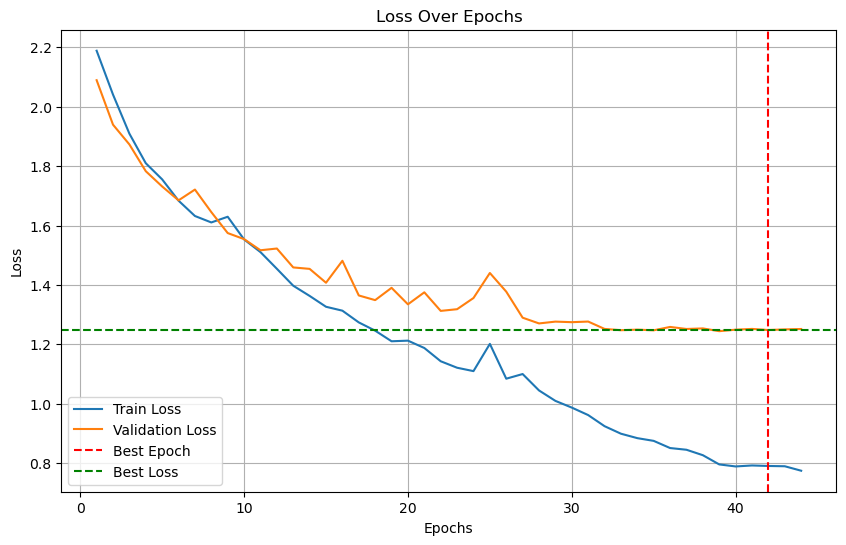

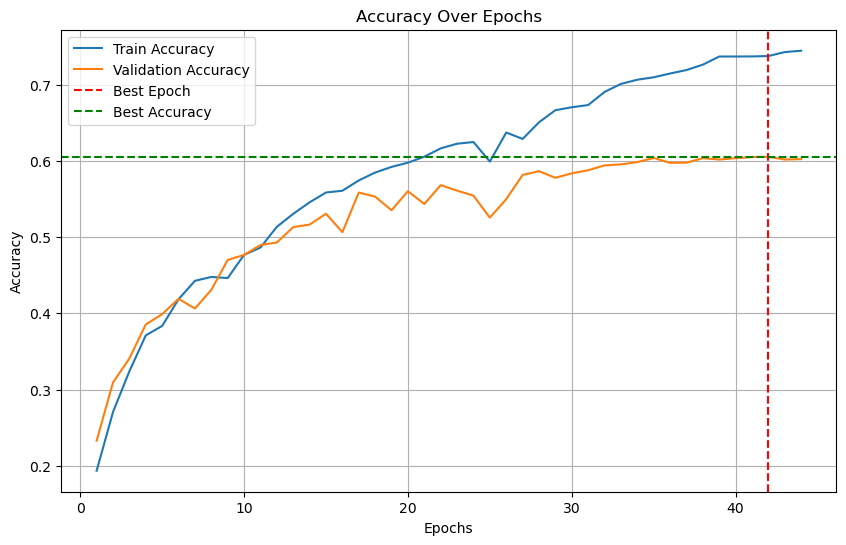

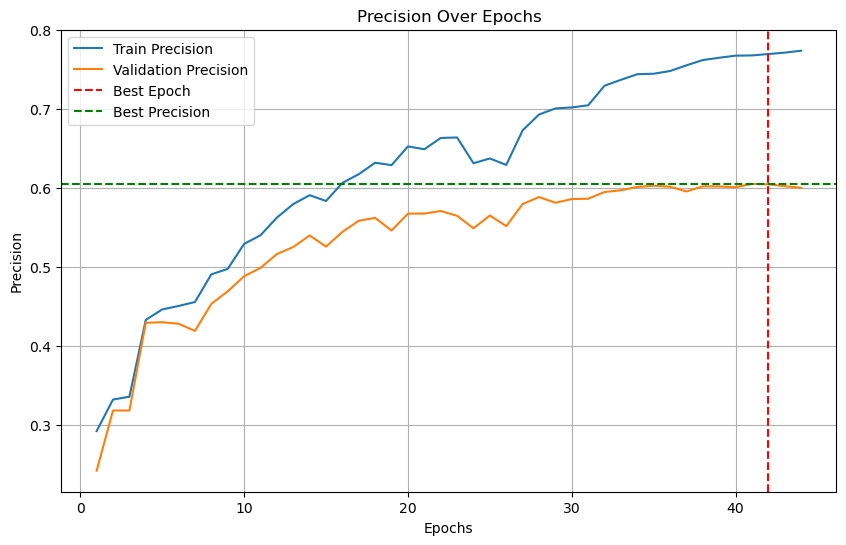

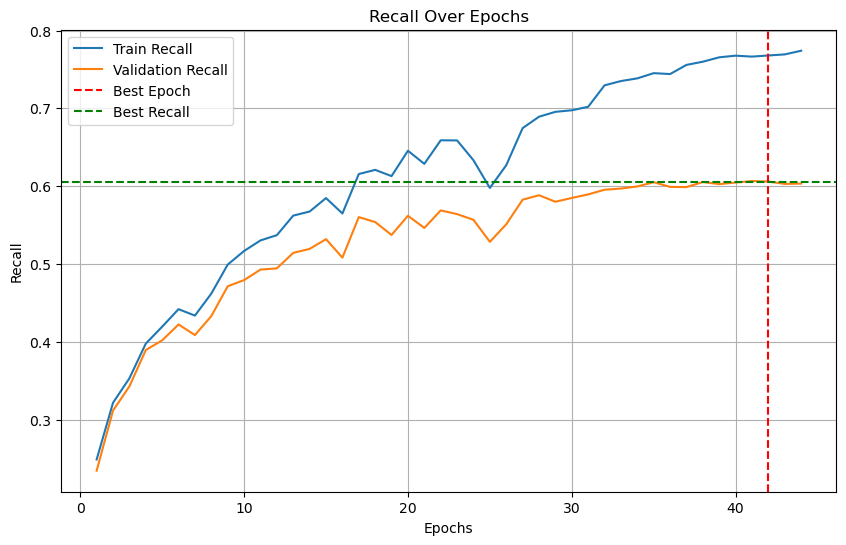

In [70]:
# Train and Evaluate the Vision Transformer
def train_vit_with_metrics():
    train_ds, val_ds = prepare_dataset()
    test_ds = val_ds

    train_batches = len(train_ds)
    val_batches = len(val_ds)
    
    vit_model = VisionTransformer(num_classes=10, input_shape=(224, 224, 3))
    vit_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"]
    )

    # Callbacks
    metrics_callback = MetricsCallback(train_ds, val_ds)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )

    # Train the model
    vit_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        steps_per_epoch=train_batches,
        validation_steps=val_batches,
        callbacks=[metrics_callback, early_stopping, reduce_lr]
    )

    # Display metrics of the best epoch
    print(f"\nTraining Complete. Best Epoch: {metrics_callback.best_epoch + 1}")
    print(f"Training Metrics -> Loss: {metrics_callback.history['loss'][metrics_callback.best_epoch]:.4f}, "
          f"Accuracy: {metrics_callback.history['accuracy'][metrics_callback.best_epoch]:.4f}, "
          f"Precision: {metrics_callback.history['precision'][metrics_callback.best_epoch]:.4f}, "
          f"Recall: {metrics_callback.history['recall'][metrics_callback.best_epoch]:.4f}")
    print(f"Validation Metrics -> Loss: {metrics_callback.history['val_loss'][metrics_callback.best_epoch]:.4f}, "
          f"Accuracy: {metrics_callback.history['val_accuracy'][metrics_callback.best_epoch]:.4f}, "
          f"Precision: {metrics_callback.history['val_precision'][metrics_callback.best_epoch]:.4f}, "
          f"Recall: {metrics_callback.history['val_recall'][metrics_callback.best_epoch]:.4f}")

    # Evaluate the model on the test dataset using the best epoch
    test_loss, test_accuracy = vit_model.evaluate(test_ds)
    test_precision, test_recall = metrics_callback.calculate_metrics(test_ds, vit_model)
    print(f"\nTest Metrics -> Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, "
          f"Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")

    # Generate and display the plots
    metrics_callback.plot_metrics()

# Call the function to start training
train_vit_with_metrics()